In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df = yf.download('ETH-USD', start='2019-01-01', end='2021-12-31')

# Użyjemy tylko kolumny 'Close' jako cechy
data = df[['Close']].values
data

[*********************100%***********************]  1 of 1 completed


array([[ 140.81941223],
       [ 155.04768372],
       [ 149.13500977],
       ...,
       [3800.89306641],
       [3628.53173828],
       [3713.85205078]])

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.00770764],
       [0.01073007],
       [0.00947408],
       ...,
       [0.78519742],
       [0.74858363],
       [0.76670776]])

In [4]:
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

In [7]:
look_back = 60
X, Y = create_dataset(scaled_data, look_back)

In [8]:
# Reshape danych wejściowych do formatu [próbki, timesteps, cechy]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Podział na zbiór treningowy i testowy (80% treningowy, 20% walidacyjny)
train_size = int(len(X) * 0.7)
X_train, X_val = X[:train_size], X[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]

In [9]:
# Budowa modelu LSTM
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.3))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dense(25))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\Michał\Desktop\crypto\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,371 (1.95 MB)

 Trainable params: 512,371 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Trenowanie modelu z walidacją
history = model.fit(X_train, Y_train, epochs=25, batch_size=64, validation_data=(X_val, Y_val), verbose=1)
history

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - loss: 0.0024 - val_loss: 0.0453
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 6.9867e-04 - val_loss: 0.0079
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 2.1010e-04 - val_loss: 0.0081
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 2.0486e-04 - val_loss: 0.0169
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 1.5493e-04 - val_loss: 0.0092
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 1.0858e-04 - val_loss: 0.0065
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 1.2495e-04 - val_loss: 0.0071
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 1.1370e-04 - val_loss: 0.0071
Epoch 9/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 1.3149e-04 - val_loss: 0.0061
Epoch 10/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 1.6317e-04 - val_loss: 0.0071
Epoch 11/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 1.3054e-04 - val_loss: 0.0050
Epoch 12/25


In [11]:
# Predykcja na zbiorze walidacyjnym
predicted_val = model.predict(X_val)
predicted_val = scaler.inverse_transform(predicted_val)
print(predicted_val)
Y_val_inverse = scaler.inverse_transform(Y_val.reshape(-1, 1))
print(Y_val_inverse)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
[[1987.5692]
 [1984.5521]
 [1964.7112]
 [1926.9839]
 [1875.0128]
 [1816.1694]
 [1756.031 ]
 [1705.8573]
 [1668.0956]
 [1646.1737]
 [1637.9664]
 [1639.6096]
 [1652.0203]
 [1675.6016]
 [1711.641 ]
 [1757.8982]
 [1806.4504]
 [1852.1097]
 [1888.994 ]
 [1920.6528]
 [1945.7228]
 [1961.3778]
 [1968.1794]
 [1968.5858]
 [1963.4578]
 [1955.9286]
 [1948.0967]
 [1940.3955]
 [1929.5447]
 [1914.6686]
 [1893.5189]
 [1867.3594]
 [1843.207 ]
 [1825.5256]
 [1814.8146]
 [1815.3844]
 [1827.9319]
 [1852.6119]
 [1888.2446]
 [1937.0183]
 [1990.6049]
 [2044.392 ]
 [2094.525 ]
 [2138.3047]
 [2168.261 ]
 [2187.161 ]
 [2197.2036]
 [2203.3328]
 [2209.2595]
 [2215.8035]
 [2229.1663]
 [2255.5403]
 [2297.218 ]
 [2346.9207]
 [2394.1985]
 [2428.73  ]
 [2444.4124]
 [2448.1438]
 [2446.9087]
 [2446.583 ]
 [2448.2158]
 [2446.0315]
 [2442.303 ]
 [2447.0232]
 [2467.8298]
 [2507.1802]
 [2560.9849]
 [2622.6157]
 [2691.2883]
 [2762.458 ]
 [2848.398 ]
 [2941.1191]
 [3041.386 ]
 [3142.297 

In [12]:
# Pobranie dat dla zbioru walidacyjnego
validation_dates = df.index[look_back + train_size:]

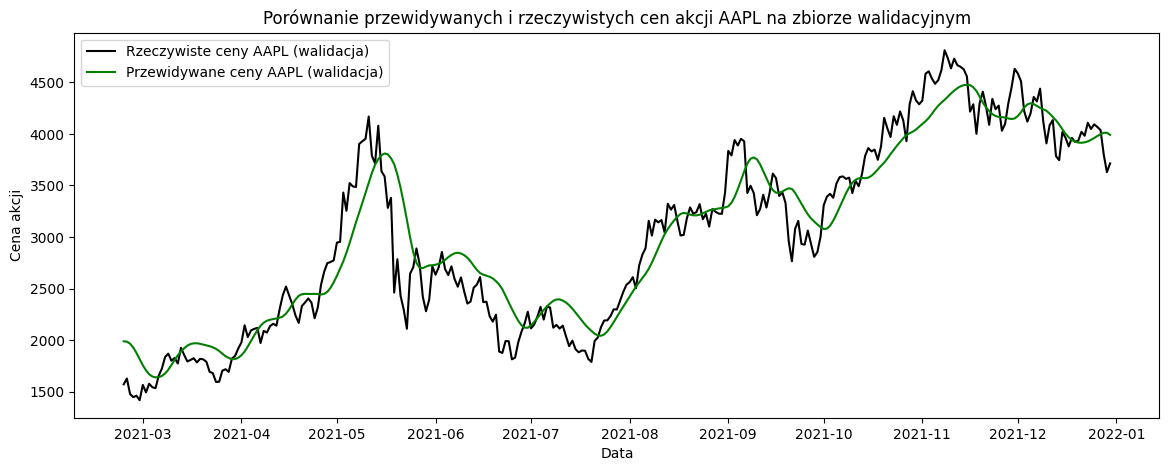

In [13]:
plt.figure(figsize=(14,5))
plt.plot(validation_dates, Y_val_inverse, color='black', label='Rzeczywiste ceny AAPL (walidacja)')
plt.plot(validation_dates, predicted_val, color='green', label='Przewidywane ceny AAPL (walidacja)')
plt.title('Porównanie przewidywanych i rzeczywistych cen akcji AAPL na zbiorze walidacyjnym')
plt.xlabel('Data')
plt.ylabel('Cena akcji')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


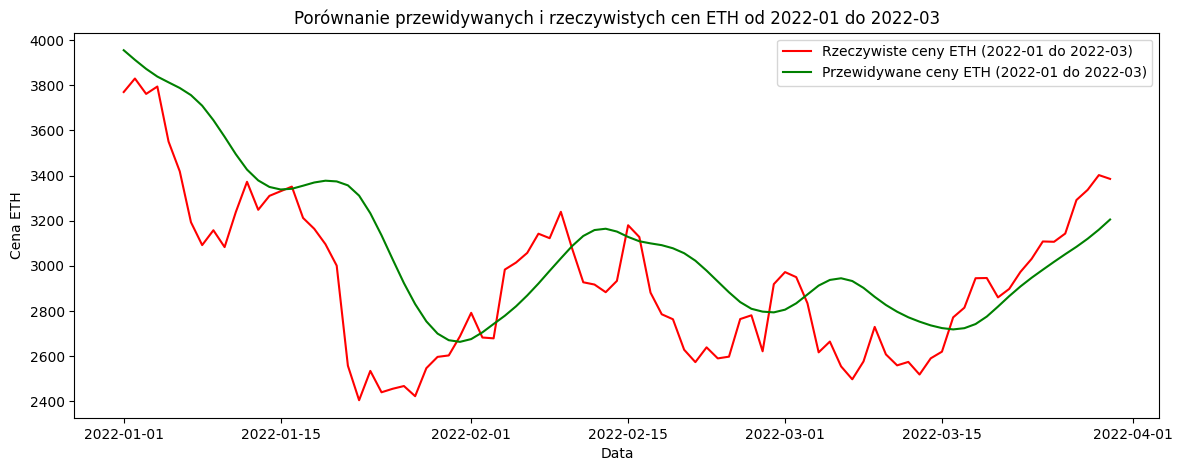

In [14]:
# Mamy już dane do 31-12-2021 w 'df', więc możemy z nich skorzystać
train_close = df[['Close']].values  # To są te same dane, które były używane do trenowania

# Pobranie nowych danych dla okresu od 2022-01-01 do 2022-03-31
test_data = yf.download('ETH-USD', start='2022-01-01', end='2022-03-31')
actual_prices = test_data[['Close']].values

# Łączenie danych treningowych i testowych w celu utrzymania ciągłości
total_dataset = np.concatenate((train_close, actual_prices), axis=0)

# Przygotowanie danych do predykcji
inputs = total_dataset[len(total_dataset) - len(actual_prices) - look_back:]
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

# Tworzenie sekwencji danych do predykcji
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predykcja cen od 2022-01-01 do 2022-03-31
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Rzeczywiste ceny zamknięcia dla tego okresu
real_prices = test_data['Close'].values

# Daty dla okresu predykcji
test_dates = test_data.index

# Wykres porównujący rzeczywiste ceny z przewidywanymi
plt.figure(figsize=(14,5))
plt.plot(test_dates, real_prices, color='red', label='Rzeczywiste ceny ETH (2022-01 do 2022-03)')
plt.plot(test_dates, predicted_prices, color='green', label='Przewidywane ceny ETH (2022-01 do 2022-03)')
plt.title('Porównanie przewidywanych i rzeczywistych cen ETH od 2022-01 do 2022-03')
plt.xlabel('Data')
plt.ylabel('Cena ETH')
plt.legend()
plt.show()
